Odtworzenie wyników analizy z [1]

1. Wczytanie danych z pliku csv

In [2]:
import numpy as np
import matplotlib.pyplot as plt

(10, 1000.0)

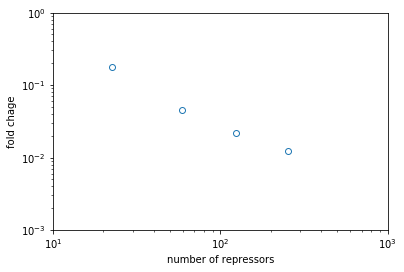

In [53]:
#lacZ_titration_data = np.genfromtxt('lacZ_titration_data-2.csv', delimiter=',', usecols = (0, 1), names=True)
lacZ_titration_data = np.loadtxt('lacZ_titration_data-2.csv', delimiter=',', skiprows=1, usecols = (0,1))

plt.plot(lacZ_titration_data.T[0], lacZ_titration_data.T[1], 'o', markerfacecolor='w')
plt.xlabel('number of repressors')
plt.ylabel('fold chage')
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-3, 1])
plt.xlim([10, 1e3])


In [54]:
lacZ_titration_data

array([[2.242e+01, 1.756e-01],
       [5.934e+01, 4.519e-02],
       [1.240e+02, 2.151e-02],
       [2.553e+02, 1.241e-02]])

TypeError: Cannot cast array data from dtype([('repressor', '<f8'), ('fold_change', '<f8')]) to dtype('float64') according to the rule 'unsafe'

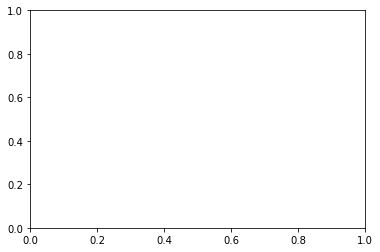

[1] Nonlinear Regression